# RNAKG

## Install packages

In [24]:
!nvidia-smi

Fri Jul 19 08:16:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          Off | 00000000:06:00.0 Off |                    0 |
| N/A   32C    P0              66W / 300W |   3340MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
#!pip install  matplotlib==3.5.0

In [27]:
#!pip install tikzplotlib
#!pip install tensorflow

In [28]:
#import sys
#!pip3 install -q grape -U
#!pip3 install tensorflow==2.12.0  

#!pip3 install karateclub -U
#!pip3 install tensorrt -U
#!pip install  tikzplotlib
#!pip install dot2tex
#!pip install jupyter_contrib_nbextensions
#!pip install umap
#!pip uninstall umap  
#!pip install umap-learn
#!pip install graphviz
#!pip install pandas
#!pip3 install numpy==1.23.0
#!pip3 install barplots
#!pip3 install varname
#!pip3 install matplotlib==3.6.0
#!pip3 install honto
#!pip3 install seaborn
#!pip3 install tensorflow

## Load packages

In [29]:
# basics
import numpy as np 
import pandas as pd 
import tensorflow as tf

# math
from math import ceil
from math import log
from math import log10

# utils
import itertools as it
import time
#from varname import nameof # get the name of a variable
import pickle
from tqdm.auto import tqdm, trange
#from tqdm import tqdm  RuntimeError: CUDA error: device-side assert triggered
import inspect
from grape.datasets.linqs import get_words_data # words information is excluded 
import glob


# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import tikzplotlib
from barplots import barplots
import matplotlib.colors as colors
import seaborn as sns

# torch geometrics

import torch
import torch.optim as optim

from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx, DistMult, RotatE, TransE
from torch_geometric.data import Data

import os.path as osp

# Convolutional GNN

import torch_geometric.transforms as T

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader

from sklearn.metrics import roc_auc_score

## Load RNA-KG graphs

In [30]:
# Load graph
view=1
view_name='VIEW'+str(view)
results = pd.DataFrame()

# Load graph
view_path='./PKLEma/202405/RNA-KG_VIEWS/VIEW'+str(view)+"/"

nodes_df = pd.read_pickle(view_path+"nodes.pkl")
edges_df = pd.read_pickle(view_path+"edges.pkl")

In [31]:
# TRAIN DATASET

nodes_df.to_csv(view_path+"nodes.csv", header=False, index=False, sep='\t')
edges_df.to_csv(view_path+"edges.csv", header=False, index=False, sep='\t')

### Pytorch Geometric Encoding

In [32]:
# One-hot encoding of the types
class TypeOneHotEncoder: 
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for type in col.split(self.sep):
                x[i, mapping[type]] = 1
        return x

# Integer encoding for types
class TypeIntegerEncoder: 
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), 1)
        for i, type in enumerate(df.values):
                x[i] = mapping[type]
        return x.to(torch.float)

In [33]:
def load_node_df(df, index_col, encoders=None, **kwargs):

    # Integer encoding for the types
    type_mapping: Dict[str, int] = {}
    
    df = df.set_index(index_col)
    # Create te mapping for the index
    mapping = {index: i for i, index in enumerate(df.index.unique())}
    
    # Create the features for the nodes
    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

def load_edge_df(df, src_index_col, src_mapping, dst_index_col, dst_mapping,
                 pred_index_col=None, pred_mapping=None, encoders=None, **kwargs):
    
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    # Edge Types
    edge_attr = None
    # Edge mapping
    if pred_mapping is not None:
        edge_attrs = torch.zeros(len(df), 1)
        for i, type in enumerate(df[pred_index_col].values):
            edge_attrs[i] = pred_mapping[type]
        edge_attr = edge_attrs.to(torch.int64)
    # No mapping but encoder
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)
        
    return edge_index, edge_attr

### Train

In [34]:
# Train

nodes_x, node_mapping = load_node_df(nodes_df, index_col='name', 
                                     encoders={'type': TypeIntegerEncoder()}
                                    )

# Edge type mapping (same for train/test)
pred_mapping = {index: i for i, index in enumerate(edges_df.predicate.unique())}

edge_index, edge_type = load_edge_df(
    edges_df, 
    src_index_col='subject', src_mapping = node_mapping, 
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()    
     #     }
    )


### Split train/validation

In [35]:
data = Data(x=nodes_x, edge_index=edge_index, edge_type=edge_type)

# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly, so we don't want to
# add them to the graph right away.
# Overall, we can leverage the `RandomLinkSplit()` transform for this from PyG:
from torch_geometric.transforms import RandomLinkSplit
transform = RandomLinkSplit()

train_data, val_data, test_data = transform(data)

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

In [36]:
print(f"Edges Train: {len(train_data.edge_label_index[0])}  Test:{len(test_data.edge_label_index[0])}  Validation: {len(val_data.edge_label_index[0])}") 

Edges Train: 1604594  Test:458454  Validation: 229226


### External Test

In [37]:
## EXTERNAL TEST SETS

## VIEW 0-2 
test_sets = ['miRNA-disease2bepred','SPIRES_FN','SPIRES_FP','SPIRES_TP','test-']
test_df = pd.read_csv(view_path+test_sets[0]+".csv", sep='\t')

## VIEW 3-5 
#test_df = pd.read_csv(view_path+"miRNA-disease2bepred.csv", sep='\t')
#test_sets = ['miRNA-disease2bepred']
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 6-8 
#test_df = pd.read_csv(view_path+"miRNA-gene2bepred.csv", sep='\t')
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 12-15 NO HEADERS!!
#test_df = pd.read_csv(view_path+"test.txt",names=["subject","predicate","object"], sep='\t')

In [53]:
# Remove edges with unknown nodes
sources_in_graph = test_df.subject.apply(lambda x: x in nodes_df.name.values)
destinations_in_graph = test_df.object.apply(lambda x: x in nodes_df.name.values)

edge_extremes_in_graph = [a and b for a, b in zip(sources_in_graph, destinations_in_graph)]

print([[x,edge_extremes_in_graph.count(x)] for x in set(edge_extremes_in_graph)])

edges_to_predict_filtered = test_df[edge_extremes_in_graph]

test_edge_index, test_edge_type = load_edge_df(
    edges_to_predict_filtered, 
    src_index_col='subject', src_mapping = node_mapping, 
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()    
     #     }
    )

external_test_data = Data(x=nodes_x, 
                 edge_index=test_edge_index, 
                 edge_type=test_edge_type,
                 edge_label_index=test_edge_index,
                 edge_label=torch.ones(test_edge_index.size(1))
                ).to(device)

[[False, 16], [True, 74491]]


## Methods

### Convolutinal NN

In [39]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(train_data.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

loader = LinkNeighborLoader(
    train_data,
    num_neighbors=[30] * 2,
    batch_size=128,
)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

@torch.no_grad()
def get_prob(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return out.cpu().numpy()

@torch.no_grad()
def get_emb(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return z.cpu().numpy()

best_val_auc = final_test_auc = 0

/home/mausoto/.local/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [40]:
# Training 
n_epochs=301

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 468.3955
Epoch: 002, Loss: 146.2064
Epoch: 003, Loss: 55.5519
Epoch: 004, Loss: 58.8677
Epoch: 005, Loss: 82.7673
Epoch: 006, Loss: 87.5217
Epoch: 007, Loss: 73.7432
Epoch: 008, Loss: 54.9714
Epoch: 009, Loss: 39.5032
Epoch: 010, Loss: 28.7108


In [41]:
val_auc = test(val_data)
train_auc = test(train_data)
print(f' View: {view}, Train: {train_auc}, Val: {val_auc:.4f}')
 

 View: 1, Train: 0.7797813533061483, Val: 0.7755


### Visualize

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [44]:
z = get_emb(train_data)

In [45]:
y= nodes_df['type'].astype('category').cat.codes

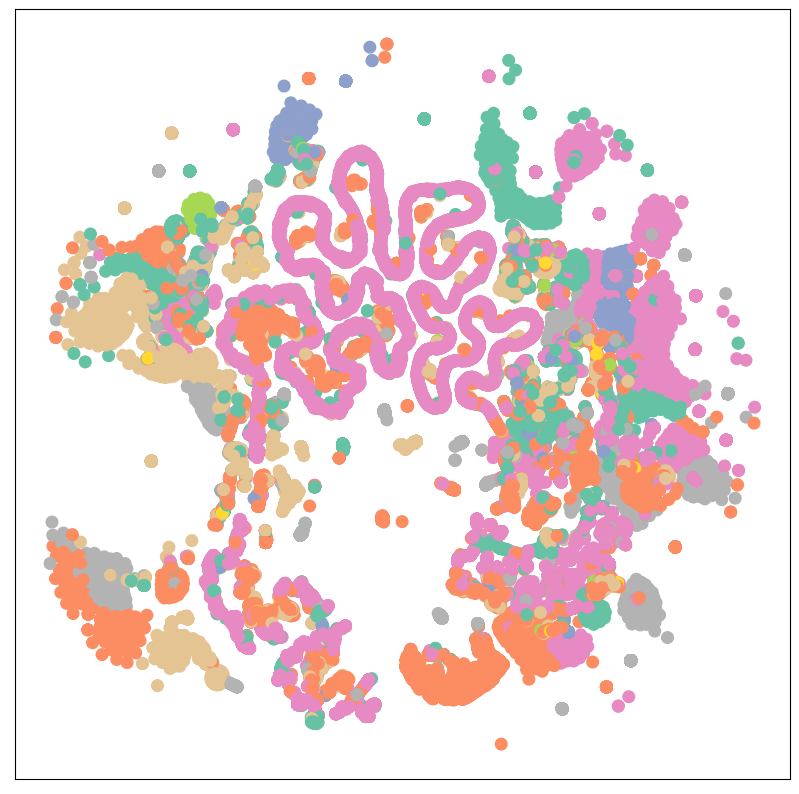

In [48]:
visualize(z,y)

### Save model/probabilities

In [150]:
#torch.save(model, view_path+'GNConv_model_view'+str(view)+'.pth')

In [55]:
probs = edges_to_predict_filtered.copy()
probs['probability']=get_prob(external_test_data)
#probs.to_csv(view_path+'predictions/view'+str(view)+'_GNConv_predictions.csv')

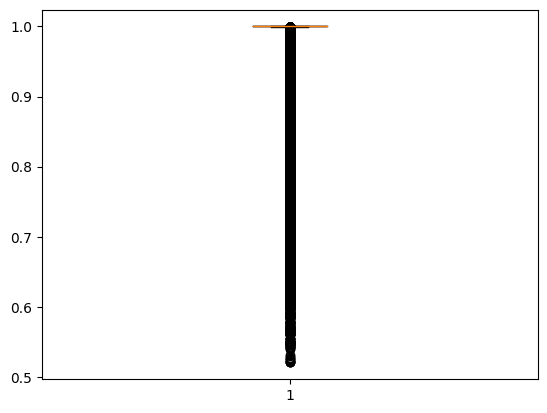

In [61]:
_=plt.boxplot(get_prob(test_data))

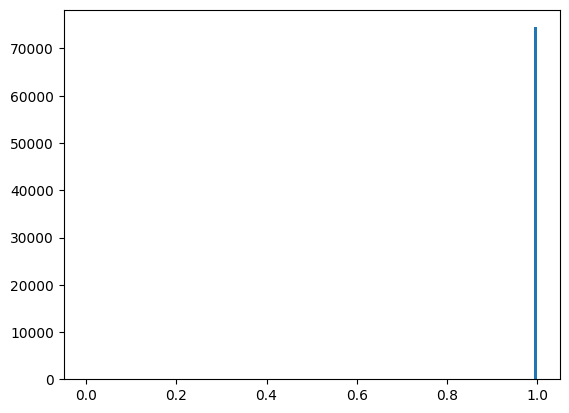

In [60]:
_=plt.hist(get_prob(external_test_data), bins=150, range=[0,1])

In [ ]:
plt.rcdefaults()
mpl.rcParams.update(mpl.rcParamsDefault)

size = 10
method = "TSNE" 

# Embedding generation
start = time.time()
embedding=Node2VecSkipGramEnsmallen(
            #embedding_size=size,
            #return_weight=param[0],
            #explore_weight=param[1], 
            #change_node_type_weight=param[2],
            #change_edge_type_weight=param[3],
            ).fit_transform(rna_kg_graph)
end = time.time()
print(f'Computed  in {end - start} s')

# Node visualization
vis = GraphVisualizer(
            graph=rna_kg_graph,
            automatically_display_on_notebooks=False,
            #node_embedding_method_name=,
            decomposition_method = method,
        )
        
vis.fit_nodes(embedding)


fig, ax = plt.subplots()
fig.suptitle("Size:"+str(size)+" Method: "+method, fontsize=16)
fig.tight_layout()

vis.plot_node_types(
        figure=fig,
        axes=ax,
        #axes=axes[index // ncols, index % ncols],
        #train_indices=train.get_node_ids_with_known_node_types(),
        #test_indices=test.get_node_ids_with_known_node_types()
        #show_legend=False,
        )


plt.show()